BERT classification of event categories

# Imports and Installations

In [2]:
# pip install simpletransformers

  Using cached simpletransformers-0.70.1-py3-none-any.whl.metadata (42 kB)
  Using cached regex-2024.5.15-cp311-cp311-macosx_10_9_x86_64.whl.metadata (40 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 786.3 kB/s eta 0:00:00 0:00:01
  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached tokenizers-0.19.1-cp311-cp311-macosx_10_12_x86_64.whl.metadata (6.7 kB)
  Using cached streamlit-1.36.0-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (7.7 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
  Using cached safetensors-0.4.3-cp311-cp311-macosx_10_12_x86_64.whl.metadata (3.8 kB)
  Using cached click-8.1.7-

In [3]:
# pip install torch

  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached sympy-1.12.1-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached sympy-1.12.1-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import re
from sklearn.model_selection import GroupShuffleSplit
import torch
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report, confusion_matrix
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

ModuleNotFoundError: No module named 'torch.utils'

In [ ]:
# Check CUDA availability and set the 'use_cuda' argument accordingly
use_cuda = torch.cuda.is_available()
use_cuda

True

# Load Data

In [ ]:
# run_in_colab = True
run_in_colab = False

In [ ]:
if run_in_colab:

    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Change the current working directory to the location where the data folder is stored
    # %cd /content/drive/MyDrive/classification_bert/

Mounted at /content/drive
/content/drive/MyDrive/Masterarbeit/Paper/code/classification_bert


In [7]:
df_train = pd.read_csv('../data/ground_truth_train.csv')
df_test = pd.read_csv('../data/ground_truth_test.csv')

In [8]:
df_train.shape, df_test.shape

((191, 15), (74, 15))

In [9]:
# assert that no documents from train are in test data
set(df_train['document']).intersection(set(df_test['document']))

set()

In [10]:
df_train.head()

,document,text,keyword,event_trigger,temporal_status,measurability,event_factuality,kw_is_nsubj,kw_is_dobj,kw_is_pobj,category,text_kw_et,text_kw,relation_time_specification,relation_unit
0,1.txt,The diverse range of the members’ educational ...,25-74 [members’ educational and professional b...,75-83 [includes],ongoing,1.0,_,False,False,True,situation,The diverse range of the members’ educational ...,The diverse range of the members’ educational ...,NaN,NaN
1,10.txt,Contributing to society by improving access to...,140-170 [Ambition Zero Carbon programme],125-135 [delivering],ongoing,2.0,3_max,False,True,False,action,Contributing to society by improving access to...,Contributing to society by improving access to...,NaN,NaN
2,10.txt,Contributing to society by improving access to...,59-83 [environmental protection],27-36 [improving],ongoing,1.0,3_max,False,False,False,action,Contributing to society by improving access to...,Contributing to society by improving access to...,NaN,NaN
3,100.txt,Our water strategy focuses on working towards ...,119-133 [water security],111-118 [support],ongoing,2.0,0_low,False,True,False,action,Our water strategy focuses on working towards ...,Our water strategy focuses on working towards ...,NaN,NaN
4,100.txt,Our water strategy focuses on working towards ...,0-18 [Our water strategy],19-26 [focuses],ongoing,1.0,3_max,True,False,False,situation,Our water strategy focuses on working towards ...,Our water strategy focuses on working towards ...,NaN,NaN


# Prepare Data for BERT

In [ ]:
def extract_content_in_brackets(text):
    """
    Extracts and returns the content within the first pair of square brackets found in the given text.
    If no square brackets are found, returns an empty string.
    """
    text = str(text)
    match = re.search(r'\[(.*?)\]', text)
    if match:
        return match.group(1)
    else:
        return ""

df_train['event_trigger'] = df_train['event_trigger'].apply(extract_content_in_brackets)
df_test['event_trigger'] = df_test['event_trigger'].apply(extract_content_in_brackets)
df_train['keyword'] = df_train['keyword'].apply(extract_content_in_brackets)
df_test['keyword'] = df_test['keyword'].apply(extract_content_in_brackets)

In [ ]:
# select relevant columns
df_train = df_train[['document', 'text', 'event_trigger', 'keyword', 'category']]
df_test = df_test[['document', 'text', 'event_trigger', 'keyword', 'category']]

In [ ]:
def format_text(row):
    sentence = row['text'].replace(row['keyword'], f"[KEYWORD] {row['keyword']} [/KEYWORD]")
    sentence = sentence.replace(row['event_trigger'], f"[TRIGGER] {row['event_trigger']} [/TRIGGER]")
    return sentence

df_train['text'] = df_train.apply(format_text, axis=1)
df_test['text'] = df_test.apply(format_text, axis=1)

In [ ]:
# rename "category" to "label"
df_train = df_train.rename(columns={'category': 'label'})
df_test = df_test.rename(columns={'category': 'label'})

# Map labels to integers if necessary
label_mapping = {'action': 0, 'intention': 1, 'belief': 2, 'situation': 3}  # Update according to your labels
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [ ]:
# Select only the necessary columns
df_train = df_train[['text', 'label']]
df_test = df_test[['text', 'label']]

In [ ]:
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

In [ ]:
set(df_train['label']), set(df_test['label'])

({0, 1, 2, 3}, {0, 1, 2, 3})

In [ ]:
num_labels = len(df_train['label'].unique())
num_labels

4

In [ ]:
df_train.head()

,text,label
0,The diverse range of the [KEYWORD] members’ ed...,3
1,Contributing to society by improving access to...,0
2,Contributing to society by [TRIGGER] improving...,0
3,Our water strategy focuses on working towards ...,0
4,[KEYWORD] Our water strategy [/KEYWORD] [TRIGG...,3


# Hyperparameter Training

In [11]:

# def objective(trial):
#     model_args = ClassificationArgs(
#         num_train_epochs=trial.suggest_int("num_train_epochs", 1, 5),
#         learning_rate=trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
#         train_batch_size=trial.suggest_int("train_batch_size", 8, 32),
#         eval_batch_size=trial.suggest_int("eval_batch_size", 8, 32),
#         max_seq_length=trial.suggest_int("max_seq_length", 128, 512),
#         overwrite_output_dir=True,
#         save_steps=-1,  # Disable checkpoint saving
#         save_model_every_epoch=False  # Disable model saving every epoch
#     )

#     # Create a ClassificationModel
#     model = ClassificationModel(
#         "roberta", "roberta-base",
#         # "bert", "bert-base-uncased",
#         num_labels=num_labels,
#         args=model_args,
#         use_cuda=torch.cuda.is_available()
#     )

#     # Train the model
#     model.train_model(df_train)

#     # # Evaluate the model
#     # result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=accuracy_score)
#     # # Return the evaluation metric to optimize
#     # return result['acc']

#     # Evaluate the model
#     result, model_outputs, wrong_predictions = model.eval_model(df_test)

#     # Calculate additional metrics
#     y_pred = model_outputs.argmax(axis=1)
#     f1 = f1_score(y_test, y_pred, average='weighted')

#     # Return the F1-score to optimize
#     return f1

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=40)

# # Print the best hyperparameters and the best accuracy
# print('Best hyperparameters:', study.best_params)
# print('Best f1:', study.best_value)


# Final Model Training + Evaluation   

In [ ]:
model_args = ClassificationArgs()

model_args.num_train_epochs = 5
model_args.learning_rate = 8.521786512851659e-05
model_args.train_batch_size = 8
model_args.eval_batch_size = 24
model_args.max_seq_length = 512

model_args.output_dir = "outputs/"
model_args.overwrite_output_dir = True

In [ ]:
# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "roberta-base",
    # "bert", "bert-base-uncased",
    num_labels=num_labels,  # Number of labels
    args=model_args,
    use_cuda=use_cuda
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Train the model
model.train_model(df_train[['text', 'label']])

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/24 [00:00<?, ?it/s]

(120, 0.8786977683504422)

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test[['text', 'label']])

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      action       0.67      0.46      0.55        13
   intention       0.61      0.76      0.68        25
      belief       0.43      0.45      0.44        20
   situation       0.77      0.62      0.69        16

    accuracy                           0.59        74
   macro avg       0.62      0.57      0.59        74
weighted avg       0.61      0.59      0.59        74



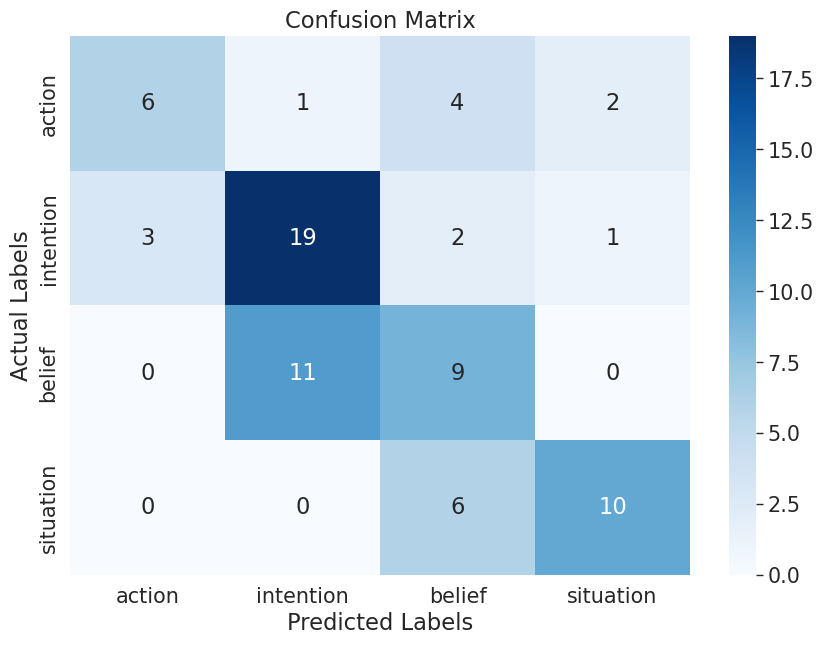

In [ ]:
# Convert model outputs to predictions
predictions = model_outputs.argmax(axis=1)

# Print classification report
print(classification_report(y_test, predictions, target_names=label_mapping.keys()))

# Create a directory to save the results
os.makedirs('results', exist_ok=True)

# Save classification report to a text file
report = classification_report(y_test, predictions, target_names=label_mapping.keys())
with open('results/classification_report.txt', 'w') as f:
    f.write(report)

# # Save hyperparameters to a JSON file
# with open('results/best_hyperparameters.json', 'w') as f:
#     json.dump(study.best_params, f, indent=4)

model_args_dict = {
    'learning_rate': model_args.learning_rate,
    'num_train_epochs': model_args.num_train_epochs,
    'train_batch_size': model_args.train_batch_size,
    'eval_batch_size': model_args.eval_batch_size,
    'max_seq_length': model_args.max_seq_length,
}

# Save hyperparameters to a JSON file
with open('results/model_args.json', 'w') as f:
    json.dump(model_args_dict, f, indent=4)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert confusion matrix to DataFrame for better label handling
cm_df = pd.DataFrame(cm, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot confusion matrix
sns.set(context="paper", font_scale=1.7)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Save the confusion matrix plot
plt.savefig('results/confusion_matrix.png', format='png', bbox_inches='tight')
plt.savefig('results/confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()